In [30]:
import os
import numpy as np
import pandas as pd
import sys
import tqdm

from scipy import optimize
from scipy import linalg
from scipy import interpolate
from scipy import signal
sys.path.append('..')
from anomalies.increasing import *
from anomalies.invariant import *
from anomalies.decreasing import *
sys.path.append('../datasets')
from data_utils import load_data_test
import matplotlib.pyplot as plt
# %matplotlib widget


## PREPARE DATASET

In [32]:
# load data
data_type = 'ecg'
if data_type == 'ecg':
    channels = ['z']
    n = 256
    SNRdB = 40
elif data_type == 'bridge':
    channels = ['x']
    n = 100
    SNRdB = None
elif data_type == 'satellite':
    channels = 'RW3_motcurr'
    n = 150
    SNRdB = None

Xok_test = load_data_test(channels, n, data_type)[..., -1]

## Generate Anomalies with a given deviation

In [34]:
delta = 0.8

In [35]:
anomalies_labels = [
    'GWN', 'Constant', 'Step', 'Impulse',
    'GNN',
    'TimeWarping', 'SpectralAlteration', 'PrincipalSubspaceAlteration',
    'MixingGWN', 'MixingConstant',
    'Clipping', 'Dead-Zone'
]

# create anomalies class instance
anomalies = [
    GWN(delta), Constant(delta), Step(delta), Impulse(delta),
    GNN(delta),
    TimeWarping(delta), SpectralAlteration(delta), PrincipalSubspaceAlteration(delta),
    MixingGWN(delta), MixingConstant(delta),
    Clipping(delta), DeadZone(delta)
]

anomalies_dict = dict(zip(anomalies_labels, anomalies))


In [36]:
MixingConstant(delta)

In [37]:
# initialize the dataframe for anomalous data
Xko_df = pd.DataFrame(
    index=np.arange(Xok_test.shape[0]),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(Xok_test.shape[1])])
)

In [38]:
# generate anomalous data for each anomaly
for name, anomaly in tqdm.tqdm(anomalies_dict.items()):
    if name in ['SpectralAlteration']:
        anomaly.fit(Xok_test, SNRdB)
    else:
        anomaly.fit(Xok_test)
    # Xko_df.loc[0, name] = anomaly.distort(ECG_test.values[0])
    Xko_df[name] = anomaly.distort(Xok_test)

100%|███████████████████████████████████████████| 12/12 [05:22<00:00, 26.88s/it]


In [39]:
# check deviation levels through Monte Carlo
print('deviation for :\n')
for name in anomalies_dict.keys():
    print(f'{name}: {np.round(np.mean(np.sum((Xok_test - Xko_df[name].values)**2, axis=1))/Xok_test.shape[-1], 3)}')

deviation for :

GWN: 0.8
Constant: 0.8
Step: 0.8
Impulse: 0.8
GNN: 0.802
TimeWarping: 0.8
SpectralAlteration: 0.8
PrincipalSubspaceAlteration: 0.8
MixingGWN: 0.801
MixingConstant: 0.8
Clipping: 0.798
Dead-Zone: 0.797


## Plot an example for each anomaly

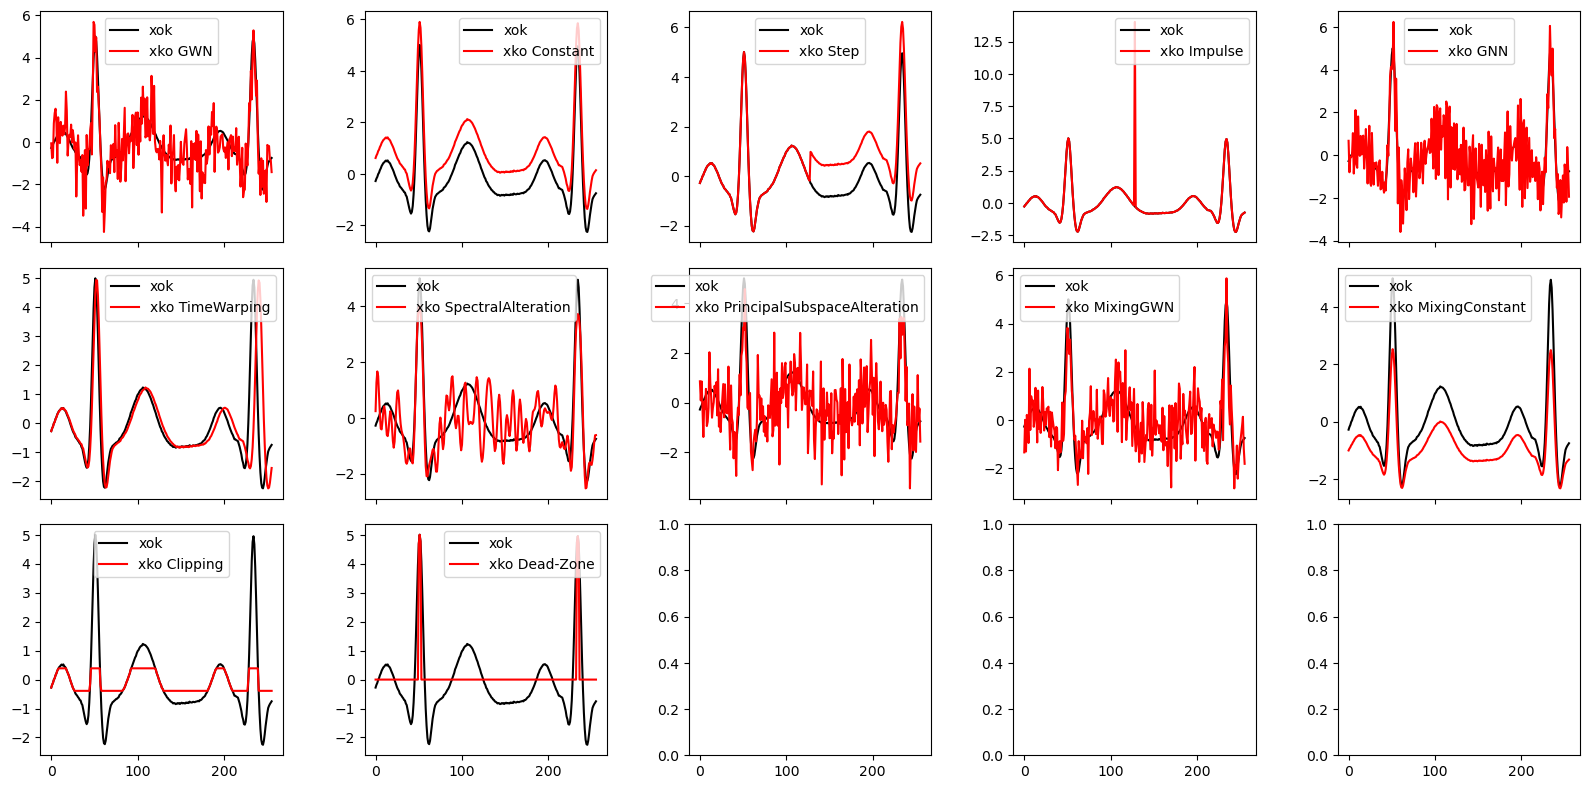

In [28]:
fig, ax = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(Xok_test[100], label='xok', c='k')
    ax_.plot(Xko_df.loc[100, name], label=f'xko {name}', c='r')
    ax_.legend()
fig.tight_layout()